# Hello Score!
Author: Charlie, Geometric AI Lab

Welcome to *beta* run of Score Based Modeling.
This notebook will help you implement basic SDE-based Diffusion Models.
You will have hands on experience deriving OU-process along with VPSDE and VESDE
and see how they affect the diffusion process. You will first build simple model 
to predict the score as well as the sampling process for a simple 2D toy dataset. You will then 
build slightly more complicated model on images. Finally, you will have to implement a different kind of 
diffusion model called Schrodinger Bridge and see their connection. The assignment breakdown into three parts:

1. Basic of SDE 
2. Learning Score and Sampling
3. Moving to MNIST
4. Schrodinger Bridge

For question please contact Charlie hieuristics@kaist.ac.kr

Codebase inspired by <https://vdeborto.github.io/project/generative_modeling/> 

### 1.1 Dataset
The following code contain the dataset that you will use throughout the first part. 

The goal of the first part is to learn the diffusion process that reverse the prior distrbution (orange) to the target distribution (blue). Once, we learned such a process, we can then sample from the prior distribution and diffusion those samples to the target distribution. 


/var/folders/sk/q6fcfx4s28jg7rsckf95wc100000gn/T/ipykernel_1088/589173951.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sample)


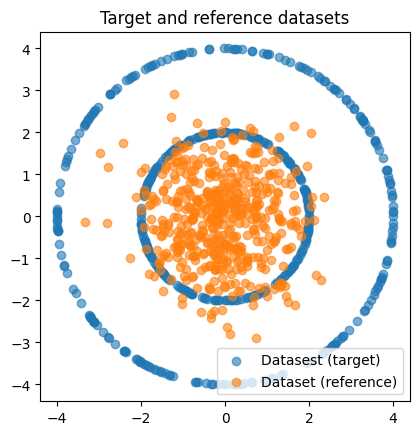

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn import datasets
import matplotlib.pyplot as plt

def load_twodim(num_samples: int,
                dataset: str,
                dimension=2) -> np.ndarray:
    """Create the two dimensional dataset array.

    Args:
        num_samples (int): number of samples.
        dataset (str): identifier of the dataset.

    Returns:
        sample (torch.tensor): (num_samples, 2) array of samples.
    """
    
    if dataset == 'gaussian_centered':
        sample = torch.randn(num_samples, dimension)
        sample = sample
    
    if dataset == 'gaussian_shift':
        sample = torch.randn(num_samples, 2)
        sample = sample + 1.5

    if dataset == 'circle':
        X, y = datasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=.5)
        sample = X * 4
        
    if dataset == 'scurve':
        X, y = datasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None)
        init_sample = X[:, [0, 2]]
        scaling_factor = 2
        sample = (init_sample - init_sample.mean()) / \
            init_sample.std() * scaling_factor
        
    return torch.tensor(sample)


class TwoDimDataClass(Dataset):
    """Create the two dimensional dataset.

    Args:
        dataset_type (str): identifier of the dataset.
        N (int): number of samples.
        batch_size (int): batch size.
    """

    def __init__(self,
                 dataset_type: str,
                 N: int,
                 batch_size: int,
                 dimension = 2):

        self.X = load_twodim(N, dataset_type, dimension=dimension)
        self.name = dataset_type
        self.batch_size = batch_size
        self.dimension = 2

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]
    
    def get_dataloader(self, shuffle=True):
        return DataLoader(self, 
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
        )

    
target_ds = TwoDimDataClass(dataset_type='circle', 
                            N=1000000, 
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

Ntest = 500
sample_f = target_ds[0:Ntest]
sample_b = prior_ds[0:Ntest]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and reference datasets"
ax.set_title(strtitle)
ax.legend(['Datasest (target)', 'Dataset (reference)'])

### 1.2 SDE Class
The following abstract base class define the abstract method that all `SDE` shares. This include a reverse process that you will have to implement. Assuming that our `SDE` are *Ornstein-Uhlenbeck* processes:

$$
\mathrm{d}\mathbf{X}_t = \mu \mathbf{X}_t \mathrm{d}t + \sigma \mathrm{d}\mathbf{B}_t, \quad\mathbf{X}_0 \sim \pi_0.
$$

Here, $\mu$ is the drift term and $\sigma$ is the diffusion term. As we know, the backward process is has the following form:

$$
\mathrm{d}\mathbf{Y}_t = \left(\mu\mathbf{Y}_t + \nabla \log_{p_{T-t}}(\mathbf{Y}_t)\right)\mathrm{d}t + \sigma \mathrm{d}\mathbf{B}_t \quad\mathbf{Y}_0 \sim \pi_T.
$$

**IMPORTANT**! The score term $\nabla p_t$ in the reverse process is the **same** score from the forward process. Therefore, in the reverse process, this score should be **reversed** as $\nabla p_{T-t}$. `self.model(t,xt)` returns the $\nabla p_{t}(\mathbf{X}_t)$. 

**TODO**: Implement the reverse diffusion process. 

In [2]:
import abc
from typing import Any

class SDE(abc.ABC):
    def __init__(self, N, T, model):
        super().__init__()
        self.N = N         # number of time step
        self.T = T         # end time
        self.model = model # score estimating network
    
    @abc.abstractmethod
    def sde_coeff(self, t, x):
        pass
    
    @abc.abstractmethod
    def marginal_prob(self, t, x):
        pass
    
    @abc.abstractmethod
    def prior_sampling(self, t, x):
        pass
    
    def reverse(self):
        '''
        Output the the same SDE class with reverse drift
        '''
        N = self.N
        T = self.T
        model = self.model
        sde_coeff = self.sde_coeff
        class RSDE(self.__class__):
            self.N = N
            self.T = T
            self.model = model
            
            def sde_coeff(self, t, x):
                drift, diffusion = sde_coeff(self.T-t, x)
                score = model(self.T-t, x)
                reverse_drift = -drift + score * (diffusion ** 2)
                return reverse_drift, diffusion
                
        return RSDE()

In [3]:
class OrnsteinUhlenbeck(SDE):
    def __init__(self, N=100):
        super().__init__(N, 1, None)
        self.N = N
        self.T = 5
        self.model = None

    def sde_coeff(self, t, x):
        drift = -0.5 * x
        diffusion = torch.ones(x.shape)
        return drift, diffusion

    def marginal_prob(self, t, x):
        mean = torch.exp(-0.5 * t).unsqueeze(1) * x
        std = torch.sqrt(1 - torch.exp(-t)).unsqueeze(1) * torch.ones_like(x)
        return mean, std

    def prior_sampling(self, shape):
        return torch.randn(shape)


sde = OrnsteinUhlenbeck()

  0%|                                                                                                        | 0/300 [00:00<?, ?it/s]/var/folders/sk/q6fcfx4s28jg7rsckf95wc100000gn/T/ipykernel_1088/2464328158.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(target_ds[range(plot_Ntest)])
100%|█████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 893.93it/s]


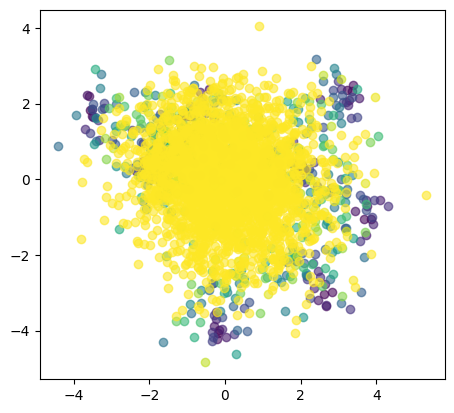

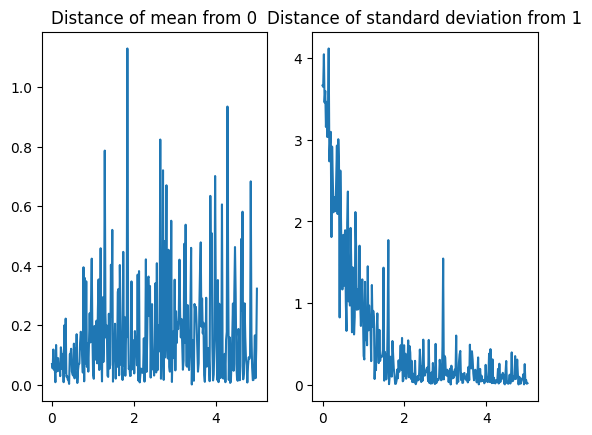

In [5]:
from tqdm import tqdm

cmap = plt.get_cmap('viridis')

n_arr = 300 # change this
plot_Ntest = 10

t_arr = np.linspace(0, sde.T, n_arr)
mean_arr = np.zeros((n_arr, 1))
std_arr = np.zeros((n_arr, 1))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for k, tt in enumerate(tqdm(t_arr)):
    x0 = torch.tensor(target_ds[range(plot_Ntest)])
    t = torch.zeros((x0.shape[0],)) + tt
    mean, std = sde.marginal_prob(t, x0)
    z = torch.randn(mean.shape)
    xt = mean + std * z

    mean_arr[k] = (xt.mean(axis=0)**2).sum()
    std_arr[k]  = ((xt.std(axis=0) - 1)**2).sum()

    ax.scatter(xt[:, 0], xt[:, 1], alpha=0.6, color=cmap(tt))

ax.grid(False)
ax.set_aspect('equal', adjustable='box')

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.plot(t_arr, np.abs(mean_arr))
plt.title("Distance of mean from 0")
ax.grid(False)
ax = fig.add_subplot(1, 2, 2)
plt.plot(t_arr, std_arr)
plt.title("Distance of standard deviation from 1")
ax.grid(False)
plt.savefig("./mean_std.jpg")

### Let's Learn Some Score!

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_timestep_embedding(timesteps,
                           embedding_dim: int,
                           max_positions=10000):
    """ Get timesteps embedding. 
    Function https: // github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py

    Args:
        timesteps (ndarray): timesteps array (Nbatch,).
        embedding_dim (int): Size of the embedding.
        max_positions (int, optional): _description_. Defaults to 10000.

    Returns:
        emb (jnp.ndarray): embedded timesteps (Nbatch, embedding_dim).
    """
    assert len(timesteps.shape) == 1
    half_dim = embedding_dim // 2
    
    # magic number 10000 is from transformers
    emb = np.log(max_positions) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = timesteps[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = F.pad(emb, [[0, 0], [0, 1]])
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb 



class MLP(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.model = nn.Sequential(
           nn.Linear(in_dim, hid_dim), nn.ReLU(),
           nn.Linear(2*hid_dim, 4*hid_dim), nn.ReLU(),
           nn.Linear(4*hid_dim, 2*hid_dim), nn.ReLU(),
           nn.Linear(2*hid_dim, out_dim)
        )

    def forward(self, x):
        return self.model(x)



class Naive(nn.Module):
    """Create a naive MLP network.

    Args:
        out_dim (int): output shape.
        enc_dim (int): The shapes of the encoder.
        t_dim (int): the dimension of the time embedding.
        dec_shapes (int): The shapes of the decoder 
        resnet (bool): if True then the network is a resnet.
    """

    def __init__(self, out_dim, enc_dim, dec_dim, t_dim):
        super().__init__()
        self.t_dim = t_dim
        t_enc_dim = t_dim * 2

        self.net = MLP(t_dim, dec_dim, out_dim)
        self.t_encoder = MLP(t_dim, enc_dim, t_enc_dim)
        self.x_encoder = MLP(t_dim, enc_dim, t_enc_dim)

    def __call__(self, t, x):
        t = torch.tensor(t)
        
        if len(x.shape) == 1:
            x = x.unsqueeze(0)

        temb = get_timestep_embedding(t.reshape(-1), self.t_dim)
        temb = self.t_encoder(temb)
        xemb = self.x_encoder(x)
        temb = temb.expand([xemb.shape[0], *temb.shape[1:]])
        h = torch.cat([xemb, temb], -1)
        out = -self.net(h)
        return out
    

model = Naive(out_dim=2, enc_dim=32, dec_dim=32, t_dim=16,)

In [28]:
from torch.optim import Adam
from ema_pytorch import EMA

class DSMLoss():
    """Compute the Denoising Score Matching loss.

    Args:
        alpha (float): regularization parameter.
        sde (Any): SDE object.
        diff_weight (bool): whether to weight the loss by the diffusion.
    """

    def __init__(self, alpha: float, diff_weight: bool):
        self.alpha = alpha
        self.diff_weight = diff_weight

    def __call__(self, pred, target, diff_sq=1):
        reg = self.alpha * pred**2
        loss = torch.norm(pred - target, 2) + reg
        
        if self.diff_weight:
            loss = loss / diff_sq.squeeze()
            
        return loss.mean()

loss_fn = DSMLoss(alpha=0, diff_weight=False)
optimizer = Adam(model.parameters(), lr=0.05)
ema =  EMA(model, beta=0.995)

In [34]:
def get_step_fn(loss_fn, optimizer, ema, sde, model):
    def step_fn(batch):
        print(batch.shape)
        batch_shape = batch.shape[0]
        
        # uniformly sample time step 
        t = sde.T*torch.rand(size=(batch_shape,1))
        
        # forward diffusion
        mean, std = sde.marginal_prob(t, batch)
        _, diffusion = sde.sde_coeff(t, batch)
        diff_sq = diffusion ** 2
        z = torch.randn(mean.shape)
        xt = mean + std * z
        
        # make training batch
        target = - z / std
        pred = model(t,xt).squeeze()
        
        # get loss
        loss = loss_fn(pred, target, diff_sq)
        
        # optimize model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema.update
    
    return step_fn


step_fn = get_step_fn(loss_fn, optimizer, ema, sde, model)

In [46]:
from tqdm import tqdm
from itertools import repeat

def repeater(data_loader):
    for loader in repeat(data_loader):
        for data in loader:
            yield data

def train_diffusion(dataloader, N_steps):
    trange = tqdm(range(0, N_steps),
                  bar_format="{desc}{bar}{r_bar}",
                  mininterval=1)
    loader = iter(repeater(dataloader))

    for step in trange:
        batch = next(loader)
        step_fn(batch)
        if step % 500 == 0:
            trange.set_description("Loss: {:.3f}".format(loss))
    

N_steps = 10000
train_diffusion(target_ds.get_dataloader(), N_steps)

                                        | 0/10000 [00:00<?, ?it/s]/var/folders/sk/q6fcfx4s28jg7rsckf95wc100000gn/T/ipykernel_55762/1917692391.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t)
                                        | 0/10000 [00:00<?, ?it/s]

torch.Size([256, 2])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x32 and 64x128)